In [48]:
import cv2
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
from tqdm import tqdm


In [37]:
df= pd.read_hdf(r'C:\Users\nlab\obstacle_avoidance\recordings\100322\J19LT\oa\raw_J19LT_100322_oa.h5')
df.head()

,first_poke,second_poke,trial_timestamps,trial_vidframes,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,...,obstacleTR_x_cm_lind,obstacleTR_y_cm_lind,obstacleBR_x_cm_lind,obstacleBR_y_cm_lind,obstacleBL_x_cm_lind,obstacleBL_y_cm_lind,obstacle_x_lind,obstacle_x_cm_lind,obstacle_y_lind,obstacle_y_cm_lind
1,63229.835737,63233.886988,"[63229.841587, 63229.857971, 63229.874572, 632...","[[1915, 1916, 1917, 1918, 1919, 1920, 1921, 19...","[569.733154296875, 569.970703125, 569.74591064...","[257.3892822265625, 257.12530517578125, 257.15...","[0.9999974966049194, 0.9999978542327881, 0.999...","[557.7861328125, 558.2794189453125, 558.036621...","[244.46926879882812, 244.72145080566406, 244.5...","[0.9999781847000122, 0.9999760985374451, 0.999...",...,31.463939,44.081228,29.339857,37.248145,24.428268,37.274052,257.011169,27.433360,330.538605,35.281675
2,63233.886988,63238.323264,"[63233.89248, 63233.909158, 63233.926592, 6323...","[2158, 2159, 2160, 2161, 2162, 2163, 2164, 216...","[113.53089904785156, 113.13566589355469, 113.7...","[265.6458435058594, 265.5018310546875, 265.546...","[0.999998927116394, 0.9999988079071045, 0.9999...","[132.0079345703125, 131.69308471679688, 131.93...","[265.60205078125, 265.60333251953125, 265.0898...","[0.9999996423721313, 0.999999463558197, 0.9999...",...,28.994327,22.531179,29.326443,37.279905,24.457417,37.302228,251.283417,26.821980,280.317204,29.921045
3,63238.323264,63246.286553,"[63238.327385, 63238.345292, 63238.36064, 6323...","[[2424, 2425, 2426, 2427, 2428, 2429, 2430, 24...","[571.6720581054688, 572.830810546875, 572.9562...","[258.0514831542969, 258.0072937011719, 258.028...","[0.9999982118606567, 0.9999984502792358, 0.999...","[550.4642333984375, 551.2725830078125, 551.811...","[257.36553955078125, 257.2220458984375, 257.58...","[0.9999930262565613, 0.9999804496765137, 0.999...",...,36.714204,24.424407,37.446869,39.046958,32.660233,39.164317,313.435879,33.456130,344.133717,36.732816
4,63246.286553,63253.692748,"[63246.297254, 63246.313676, 63246.330137, 632...","[2902, 2903, 2904, 2905, 2906, 2907, 2908, 290...","[112.93521881103516, 112.67398834228516, 112.6...","[268.1513977050781, 267.9513244628906, 267.830...","[0.9999975562095642, 0.9999984502792358, 0.999...","[131.3789520263672, 130.97537231445312, 130.83...","[266.6938171386719, 266.421875, 266.3495178222...","[0.9999986886978149, 0.9999983906745911, 0.999...",...,36.718921,24.420818,37.464358,39.065780,32.659011,39.190888,313.494228,33.462359,344.243671,36.744553
5,63253.692748,63258.067686,"[63253.699276, 63253.716531, 63253.73271, 6325...","[[3346, 3347, 3348, 3349, 3350, 3351, 3352, 33...","[567.7761840820312, 567.9352416992188, 567.834...","[260.19580078125, 259.65631103515625, 259.8600...","[0.9999910593032837, 0.9999932050704956, 0.999...","[555.2067260742188, 554.922119140625, 552.5525...","[248.92391967773438, 249.0541534423828, 250.78...","[0.999343752861023, 0.9994310140609741, 0.9991...",...,25.470267,12.858294,26.265833,27.516337,21.554206,27.611744,220.704636,23.558002,189.646877,20.242898


In [4]:
def format_frames(vid_path):
    # open the .avi file
    vidread = cv2.VideoCapture(vid_path)
    # empty array that is the target shape
    # should be number of frames x downsampled height x downsampled width
    all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                           int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                           int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH))], dtype=np.uint8)
    # iterate through each frame
    for frame_num in tqdm(range(0,int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # read the frame in and make sure it is read in correctly
        ret, frame = vidread.read()
        if not ret:
            break
        # convert to grayyscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # add the downsampled frame to all_frames as int8
        all_frames[frame_num,:,:] = frame.astype(np.int8)  
    return all_frames

In [6]:
vid = format_frames(r'C:/Users/nlab/obstacle_avoidance/recordings\100322\J19LT\oa\100322_J19LT_control_Rig2_oa_top1.avi')

100%|██████████| 33075/33075 [00:41<00:00, 801.41it/s]


In [51]:
vid = xr.DataArray(vid)

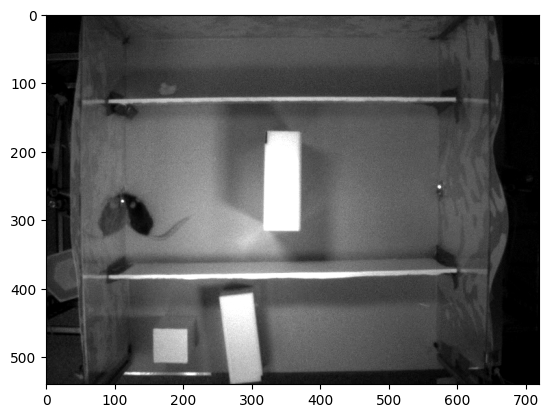

In [17]:
frame = vid[1000,:,:]
plt.imshow(frame, cmap='gray')

In [10]:
frames = vid[0:1000,:,:]

In [23]:
frames.shape

(1000, 540, 720)

In [27]:

np.array(df.at[1,'trial_vidframes'])

array([[1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
        1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
        1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
        1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
        1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
        1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
        1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
        2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
        2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
        2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
        2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
        2058, 2059, 2060, 2061, 2062, 

In [33]:
df.at[1,'trial_vidframes'].astype(int)[:,-1]

array([2157])

In [34]:
df.at[1,'trial_vidframes'].astype(int)[:,0]

array([1915])

In [52]:

for ind,row in df.iterrows():
    first_frame = row['trial_vidframes'][0]
    last_frame = row['trial_vidframes'][-1]
    df.at[ind,'trial_frames_array'] = vid[first_frame[0]:last_frame[-1],:,:].astype(object)

AttributeError: 'DataArray' object has no attribute 'take'

In [45]:
vid[first_frame[0]:last_frame[-1],:,:].astype(object).shape


(242, 540, 720)

In [33]:
row['trial_vidframes'][0]

2158

In [9]:
vid[first_frame:last_frame,:,:]

TypeError: only integer scalar arrays can be converted to a scalar index

In [14]:
first_frame[0]

1915

In [47]:
vid[first_frame[0]:last_frame[-1],:,:].shape

(242, 540, 720)

In [46]:
vid[first_frame[0]:last_frame[-1],:,:].astype(object)

array([[[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [15, 10, 12, ..., 0, 0, 0],
        [13, 11, 12, ..., 0, 0, 0],
        [13, 12, 12, ..., 0, 0, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 3, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [13, 12, 10, ..., 0, 0, 0],
        [12, 11, 10, ..., 0, 0, 0],
        [11, 11, 11, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [11, 9, 5, ..., 0, 0, 0],
        [11, 9, 6, ..., 0, 0, 0],
        [15, 12, 11, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [19, 18, 22, ..., 0, 0, 0],
        [15, 17, 17, ..., 0, 0, 0],
        [11, 16, 12, ..., 0, 0, 0]],

       [[2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
    